# Basic usage of paranet

This notebook provides a gentle introduction on how to use the `paranet` package. In this example, data will be simulated from a Weibull distribution and fit without any regularization, where each observation comes from its "own" distribution which is a function of its covariate values (no censoring occurs):

$$
\begin{align*}
t_i &\sim \text{Weibull}(\lambda_i, \alpha) \\
f_{t_i} &= \lambda_i  t_i^{\alpha-1} \exp\{ -\lambda_i t_i^{\alpha} \} \\
\lambda_i &= \exp\Bigg(\beta_0 + \sum_{j=1}^p x_{ij} \Bigg)
\end{align*}
$$

The code block below loads in the necesarry pacakges and then generates data from this distribution using the inverse method.

In [1]:
# Load modules
import numpy as np
import pandas as pd
import plotnine as pn
from scipy import stats
from paranet.models import parametric

# Create a toy dataset
n, p, seed = 100, 5, 2
x = stats.norm().rvs([n,p],seed)
shape = 2
b0 = 0.25
beta = stats.norm(scale=0.5).rvs([p,1],seed)
eta = x.dot(beta).flatten() + b0
scale = np.exp(eta)
t = (-np.log(stats.uniform().rvs(n,seed))/scale)**(1/shape)  # Measurement values
d = np.ones(n)  # Censoring indicator

Next, an unregularized model is fit. Because the time ranges and covariate feature ranges are reasonable, and no regularization is used, the `scale_t` and `scale_x` arguments are set to `False`. After the model is fit, it will have an `alpha` and `beta` attribute that will be used for downstream inference.

In [2]:
# Fit the (unregularized) model
mdl = parametric(dist=['exponential', 'weibull', 'gompertz'], x=x, t=t, d=d, scale_t=False, scale_x=False)
mdl.fit()
print(f'Covariates:\n{np.vstack([mdl.alpha,mdl.beta]).round(2)}')

Covariates:
[[ 1.    2.43  0.91]
 [ 0.22  0.22 -0.55]
 [-0.04 -0.1  -0.03]
 [-0.1  -0.23 -0.09]
 [-0.43 -1.11 -0.68]
 [ 0.43  1.02  0.67]
 [-0.4  -0.96 -0.73]]


After the model is fit, we can then evaluate different survival quantities for a given observation. For example, the code below calculate the hazard for the time values between 1 to 2. Notice the exponential distribution (first column) is constant because the exponential distribution's hazard is constant with respect to time.

In [3]:
np.vstack([mdl.hazard(tval, x[[0]]) for tval in np.linspace(1,2,5)]).round(1)

array([[  13.1, 1023. ,   69.9],
       [  13.1, 1406.9,   87.8],
       [  13.1, 1825.4,  110.3],
       [  13.1, 2275. ,  138.5],
       [  13.1, 2753. ,  174. ]])

When new data becomes available (in this case we'll simply sample from a random normal), we can evaluate these observations in terms of their hazard, survival, and density functions. 

/Users/drysdaleerik/miniconda3/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


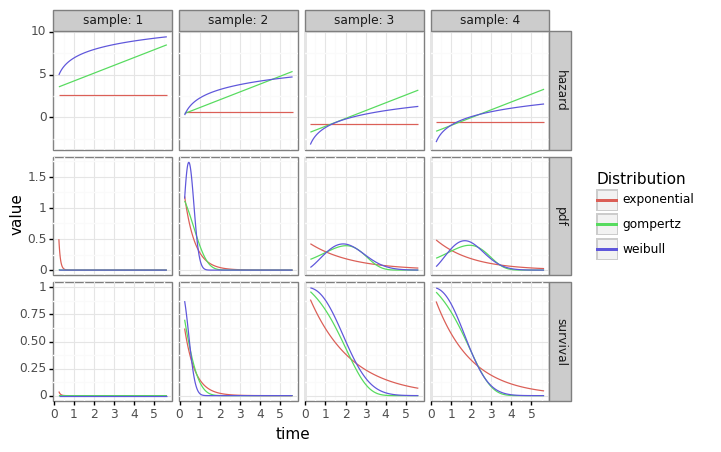

<ggplot: (8765937047902)>

In [4]:
# Draw new data
n_new = 4
x_new = stats.norm().rvs([n_new,p],seed)
# Set time range to perform inference over
n_points = 100
t_range = np.exp(np.linspace(np.log(0.25), np.log(t.max()), n_points))


methods = ['hazard', 'survival', 'pdf']
holder = []
for j in range(n_new):
    x_j = np.tile(x_new[[j]],[n_points,1])
    for method in methods:
        res_j = getattr(mdl, method)(t_range, x_j)
        if method == 'hazard':
            res_j = np.log(res_j)
        res_j = pd.DataFrame(res_j, columns = mdl.dist).assign(time=t_range,method=method, sample=j+1)
        holder.append(res_j)

# Plot the results
res = pd.concat(holder).melt(['sample','time','method'],None,'dist')

gg_res = (pn.ggplot(res, pn.aes(x='time', y='value', color='dist')) + 
    pn.theme_bw() + pn.geom_line() + 
    pn.scale_color_discrete(name='Distribution') + 
    pn.facet_grid('method~sample',scales='free',labeller=pn.labeller(sample=pn.label_both)))
gg_res